<a href="https://colab.research.google.com/github/RileyWClarke/fftpca_note/blob/master/FFTPCA_collection%2Bprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#Potentially useful astropy stuff
import astropy
import astropy.io.ascii as ascii
from astropy.table import Table
from astropy.io import fits
from astropy.stats import LombScargle
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
from astropy.modeling import powerlaws
from astropy import constants as const
from astropy import units as u

#For reading in and organizing data
import pandas as pd
import requests
import json

#Misc
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from collections import Counter
import itertools
from sklearn.preprocessing import scale
import ipywidgets as widgets
from ipywidgets import interact

In [ ]:
#Making Figures look nice
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
k2targs = pd.read_csv('/content/gdrive/My Drive/BiancoGroup/hlsp_k2varcat_k2_lightcurve_c00-c04_kepler_v2_catalog.csv')
k2targs.head()

,# ID,Campaign,Class,Class Probs (DSCUT,EA,EB,GDOR,Noise,OTHPER,RRab),Anomaly Score
0,202059070,0,Noise,0.004195,0.120507,0.016615,0.005925,0.604636,0.246088,0.002034,0.023891
1,202059073,0,Noise,0.000000,0.000760,0.000037,0.000180,0.851359,0.147664,0.000000,0.003344
2,202059074,0,Noise,0.000086,0.003688,0.000218,0.007253,0.547118,0.441569,0.000067,0.083032
3,202059078,0,Noise,0.000523,0.002839,0.000332,0.000105,0.888648,0.107552,0.000000,0.000000
4,202059080,0,Noise,0.038219,0.082267,0.022758,0.058409,0.614507,0.078915,0.104926,0.136364


In [ ]:
targets = k2targs[['# ID', ' Campaign']].values
targets

array([[202059070,         0],
       [202059073,         0],
       [202059074,         0],
       ...,
       [211203438,         4],
       [211203556,         4],
       [211203589,         4]])

In [ ]:
toi_inds = [np.where(targets[:,0] == 211046195)[0][0],
        np.where(targets[:,0] == 210327027)[0][0],
        np.where(targets[:,0] == 211110493)[0][0]]

toi_inds

[66503, 53566, 68032]

In [ ]:
urls = ['https://archive.stsci.edu/missions/k2/lightcurves/c'
        +str(target[1])+'/'+str(target[0])[0:4]+'00000/'
        +str(target[0])[4:6]+'000/ktwo'+str(target[0])
        +'-c0'+str(target[1])+'_llc.fits' for target in targets]
urls[::5000]

['https://archive.stsci.edu/missions/k2/lightcurves/c0/202000000/59000/ktwo202059070-c00_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c0/202000000/91000/ktwo202091770-c00_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201200000/35000/ktwo201235947-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201500000/09000/ktwo201509462-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201600000/98000/ktwo201698027-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201800000/93000/ktwo201893576-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c2/203500000/89000/ktwo203589087-c02_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c2/204700000/54000/ktwo204754843-c02_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c3/205900000/32000/ktwo205932262-c03_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c3/206000000/89000/ktwo206089354-c03_llc.fits',


In [ ]:
toi_urls = [urls[toi] for toi in toi_inds]
toi_urls

['https://archive.stsci.edu/missions/k2/lightcurves/c4/211000000/46000/ktwo211046195-c04_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c4/210300000/27000/ktwo210327027-c04_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c4/211100000/10000/ktwo211110493-c04_llc.fits']

In [ ]:
#Read in arrays via astropy.fits.open
def urls_to_dict(urls, campaign):
  d = {}
  for j, url in enumerate(urls):
    print()
    if url[51] == campaign:
      try:
        with fits.open(url, mode="readonly") as hdulist:
          d["k2bjds{0}".format(j)] = hdulist[1].data['TIME'] 
          d["pdcsap_flux{0}".format(j)] = hdulist[1].data['PDCSAP_FLUX']
          d["pdcsap_flux_err{0}".format(j)] = hdulist[1].data['PDCSAP_FLUX_ERR']

      except: 
        print('Loop '+str(j)+' : File not found')

  return d

In [ ]:
d0 = urls_to_dict(urls[67000:68000], campaign='4')

In [ ]:
dtoi = urls_to_dict(toi_urls, campaign='4')

In [ ]:
nanseries = []
for filename in d0:
  nanseries.append(d0[filename])

In [ ]:
np.save('/content/gdrive/My Drive/BiancoGroup/nanseries', nanseries)

In [ ]:
nanseries = np.load('gdrive/My Drive/BiancoGroup/nanseries.npy')

In [ ]:
bjds = nanseries[::3]
fluxes = nanseries[1::3]
fluxerrs = nanseries[2::3]

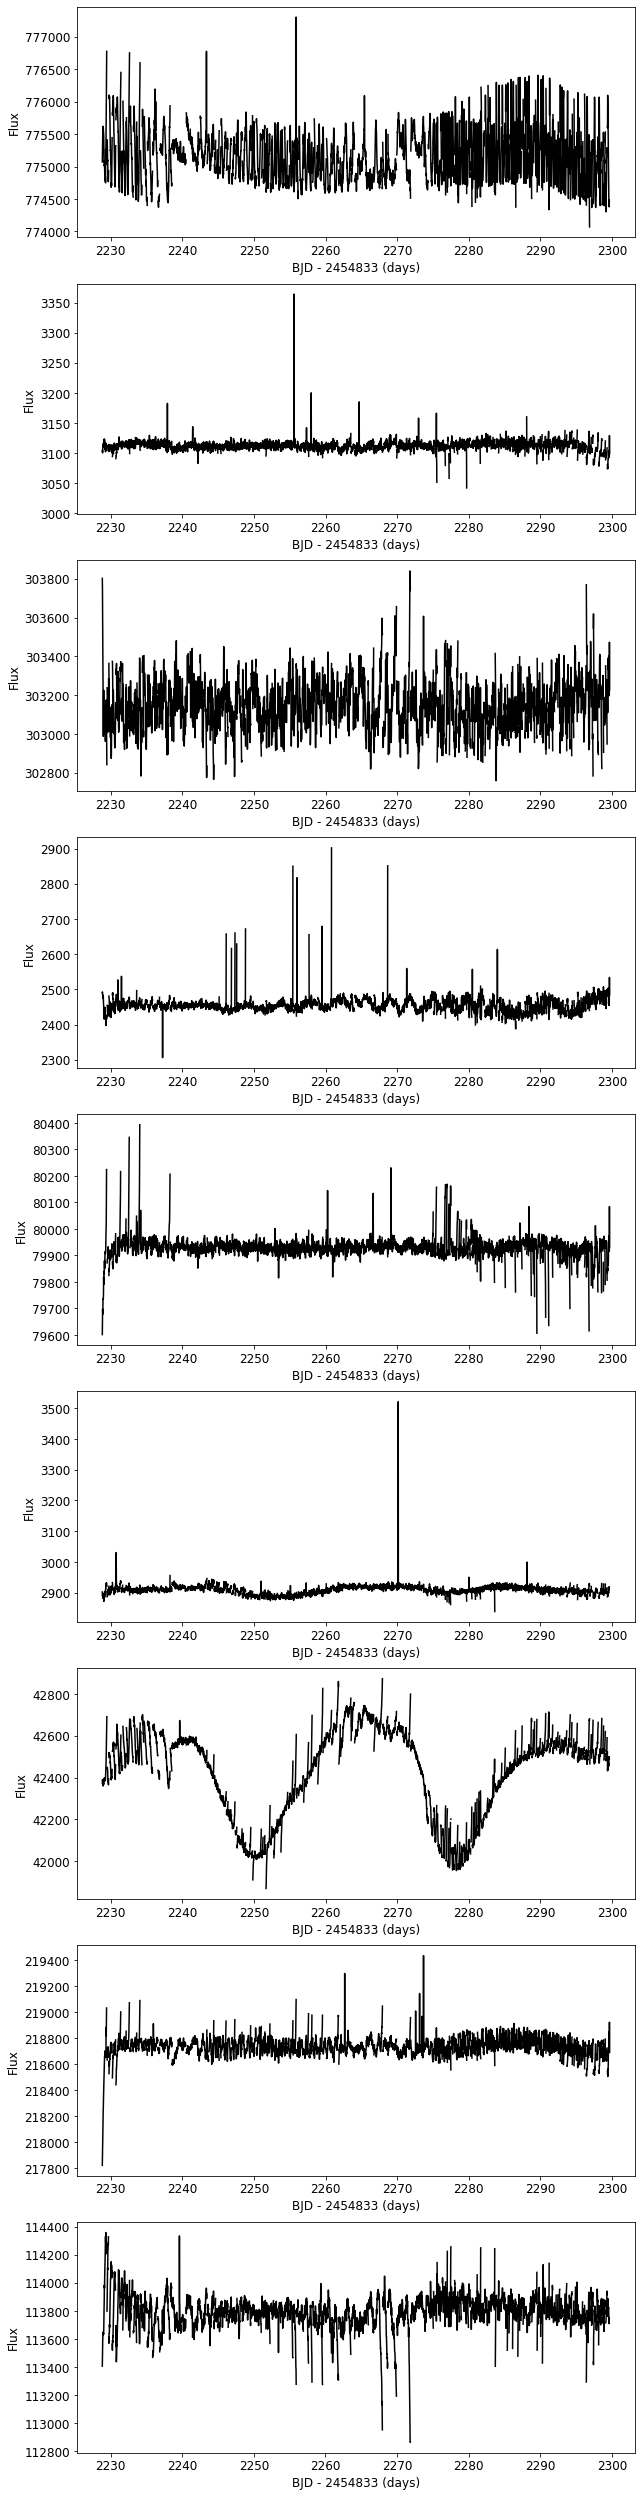

In [ ]:
fig, axes = plt.subplots(9, figsize=(10,45))
p = 0
for i in range(0,900,100):
  #fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])
  axes[p].plot(bjds[i], fluxes[i], c='k')
  axes[p].set_ylabel('Flux')
  axes[p].set_xlabel('BJD - 2454833 (days)')
  p += 1
plt.savefig('gdrive/My Drive/nanseries.png', dpi=100)


## Truncation & Normalization

In [ ]:
#Remove initial data gap
def trunc(bjds, fluxes, fluxerrs, start):
  l1 = []
  l2 = []
  l3 = []
  for i in range(len(bjds)):
    l1.append(bjds[i][start:])
    l2.append(fluxes[i][start:])
    l3.append(fluxerrs[i][start:])

  return l1, l2, l3

In [ ]:
start = np.where(np.abs(fluxes[0]) >= 1)[0][0]
bjds, fluxes, fluxerrs = trunc(bjds, fluxes, fluxerrs, start)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


In [ ]:
#Normalize flux values
for i in range(len(fluxes)):
  fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])

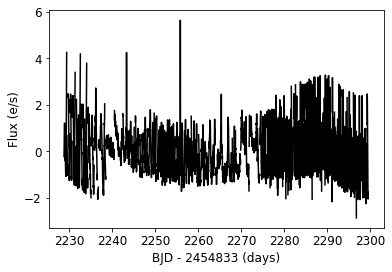

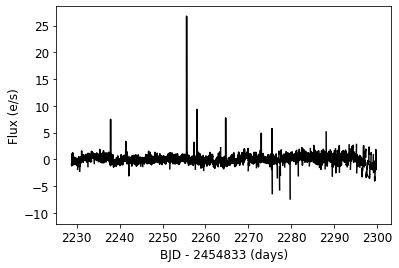

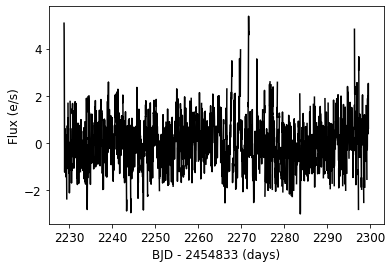

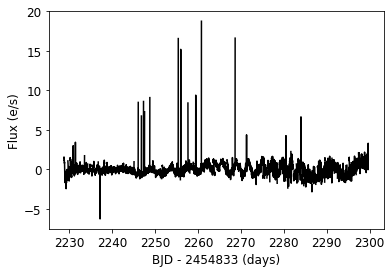

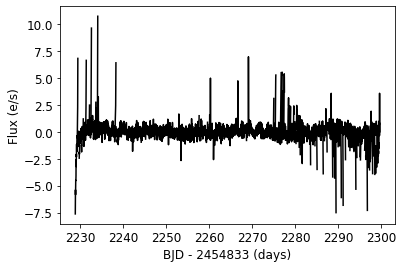

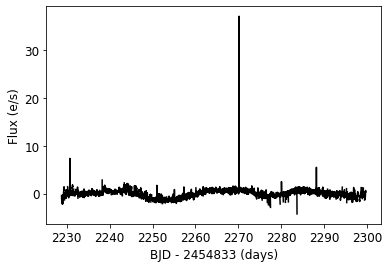

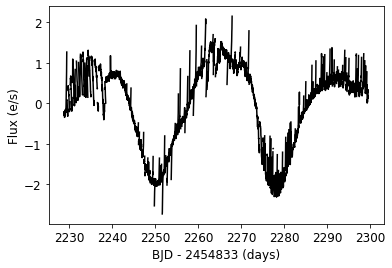

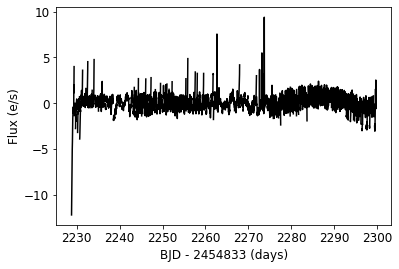

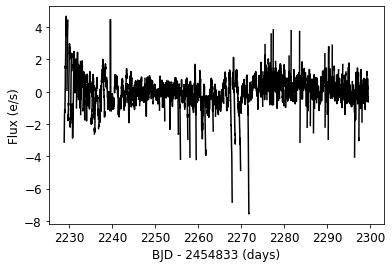

In [ ]:
for i in range(0,900,100):
  plt.plot(bjds[i], fluxes[i], c='k')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Flux (e/s)')
  plt.show()

In [ ]:
#Test for NaNs:
a = []
for j in range(len(bjds)):
  a.append(np.any(np.isnan(bjds[j]) == True))
  a.append(np.any(np.isnan(fluxes[j]) == True))
  a.append(np.any(np.isnan(fluxerrs[j]) == True))
np.any(a)#If NaNs exist, this returns True

True

## Linear Interpolation

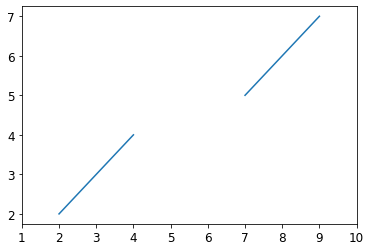

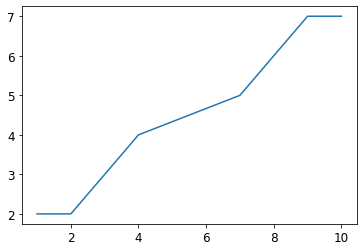

In [ ]:
#Simple linear interpolation model:
x = [1,2,3,4,5,6,7,8,9,10]
y = [np.nan,2,3,4,np.nan,np.nan,5,6,7,np.nan]

plt.plot(x,y)
plt.xlim(1,10)
plt.show()

if np.isnan(y[0]) == True:
  for i,j in enumerate(y):
    if np.isnan(j) == False:
      y[:i] = np.full(i, j)
      break
    else:
      pass

if np.isnan(y[-1]) == True:
  for i,j in enumerate(y[::-1]):
    if np.isnan(j) == False:
      y[-i:] = np.full(i, j)
      break
    else:
      pass

bools = np.isnan(y)
edges = np.diff(bools)
edgeindx = np.where(~(edges == 0))[0]+1

for i, edge in enumerate(edgeindx):
  if i%2 == 0:

    a, b = np.polyfit((x[edge-1], x[edgeindx[i+1]]), (y[edge-1], y[edgeindx[i+1]]) , 1)
    ynew = a * np.array(x[edge:edgeindx[i+1]]) + b

  else:
    continue
  
  y[edge:edgeindx[i+1]] = ynew

plt.plot(x,y)

In [ ]:
def lin_interp_nans(time, flux):
    newflux = np.copy(flux)

    #if series tip/tail is nan, replace with first/last real value:

    if np.isnan(newflux[0]) == True:
      for i,j in enumerate(newflux):
        if np.isnan(j) == False:
          newflux[:i] = np.full(i, j)
          break
        else:
          pass

    if np.isnan(newflux[-1]) == True:
      for i,j in enumerate(newflux[::-1]):
        if np.isnan(j) == False:
          newflux[-i:] = np.full(i, j)
          break
        else:
          pass

    #patching:
    bools = np.isnan(newflux)
    edges = np.diff(bools)
    edgeindx = np.where(~(edges == 0))[0]+1
    
    for i, edge in enumerate(edgeindx):
    
      if i%2 == 0:
      
        a, b = np.polyfit( (edge-1, edgeindx[i+1]),
                           (flux[edge-1], flux[edgeindx[i+1]]), deg = 1)
        
        patch = a * np.arange(edge,edgeindx[i+1]) + b 
        
      else:
        continue

      newflux[edge:edgeindx[i+1]] = patch
      
    return newflux

In [ ]:
#Interpolate the flux arrays:
for i, flux in enumerate(fluxes):
  fluxes[i] = lin_interp_nans(bjds[i], flux)

In [ ]:
#Test for NaNs:
a = []
for j in range(len(fluxes)):
  a.append(np.any(np.isnan(fluxes[j]) == True))
np.any(a)#If NaNs exist, this returns True

False

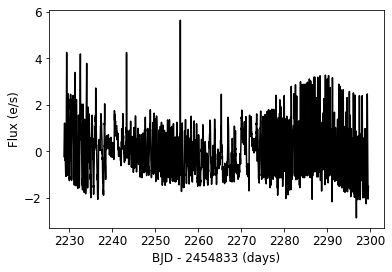

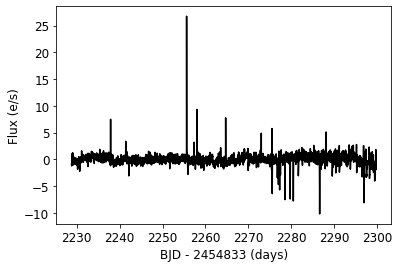

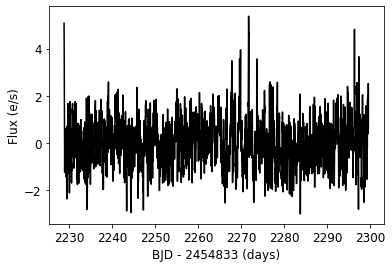

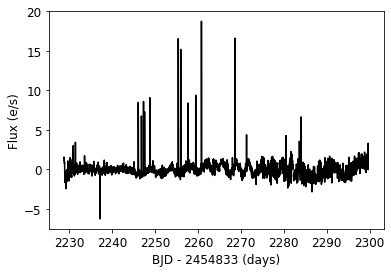

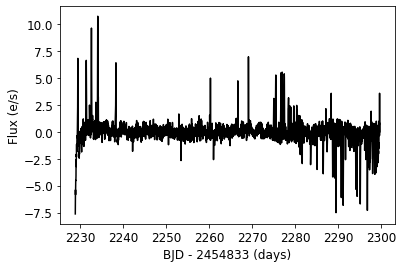

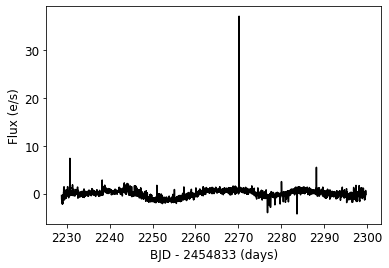

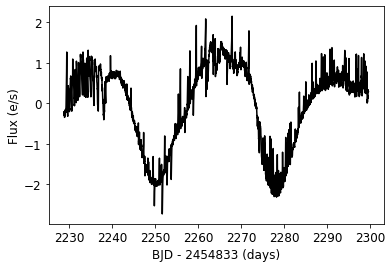

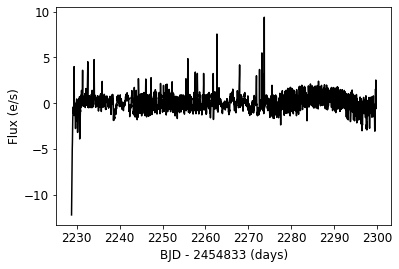

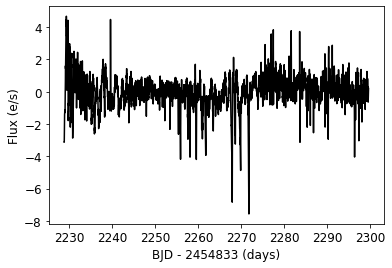

In [ ]:
for i in range(0,900,100):
  plt.plot(bjds[i], fluxes[i], c='k')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Flux (e/s)')
  plt.show()

In [ ]:
np.save('gdrive/My Drive/BiancoGroup/bjds', bjds)
np.save('gdrive/My Drive/BiancoGroup/fluxes', fluxes)
np.save('gdrive/My Drive/BiancoGroup/fluxerrs', fluxerrs)